In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
recipes_df = pd.read_csv("recipes_with_final_embeddings.csv")  
bert_embeddings = np.load("bert_embeddings.npz")
bert_embeddings = bert_embeddings['embeddings'] 
from sklearn.preprocessing import normalize
bert_embeddings = normalize(bert_embeddings) 

input_dim = bert_embeddings.shape[1]  
latent_dim = 64 


In [ ]:
from tensorflow.keras import layers, Sequential, regularizers, models

# Encoder
encoder = Sequential([
    layers.InputLayer(input_shape=(bert_embeddings.shape[1],)),  
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu', activity_regularizer=regularizers.l1(1e-5))  
])

# Decoder
decoder = Sequential([
    layers.InputLayer(input_shape=(32,)),  
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(bert_embeddings.shape[1], activation='sigmoid')  
])

inputs = layers.Input(shape=(bert_embeddings.shape[1],))
latent = encoder(inputs)  # Encoder processes the input
outputs = decoder(latent)  # Decoder reconstructs the input
autoencoder = models.Model(inputs, outputs)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9
)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mse')


history = autoencoder.fit(bert_embeddings, bert_embeddings, epochs=5, batch_size=32, shuffle=True)

latent_embeddings = encoder.predict(bert_embeddings)

print("Latent Space Embeddings for Recipes:")
print(latent_embeddings)


Epoch 1/5


D:\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0445
Epoch 2/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 3/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 4/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012
Epoch 5/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3811e-04
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
Latent Space Embeddings for Recipes:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


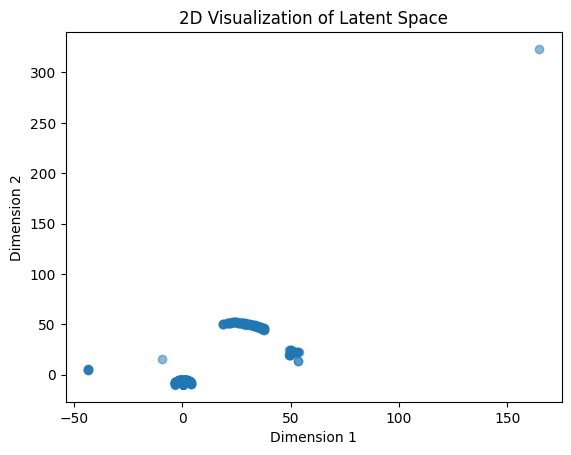

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

latent_embeddings_2d = TSNE(n_components=2).fit_transform(latent_embeddings)

plt.scatter(latent_embeddings_2d[:, 0], latent_embeddings_2d[:, 1], alpha=0.5)
plt.title("2D Visualization of Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


Loss over epochs:
Epoch 1: Loss = 0.0118
Epoch 2: Loss = 0.0010
Epoch 3: Loss = 0.0013
Epoch 4: Loss = 0.0012
Epoch 5: Loss = 0.0009


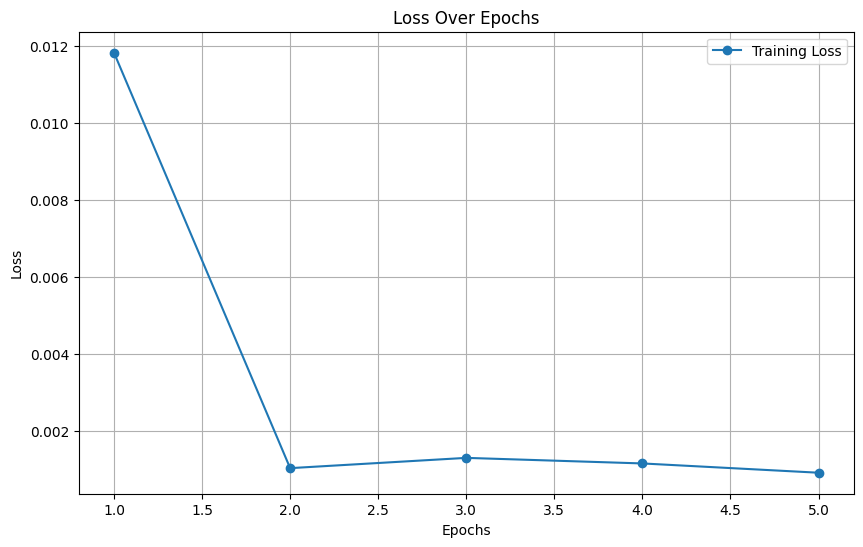

In [ ]:
loss = history.history['loss']

print("Loss over epochs:")
for epoch, value in enumerate(loss, 1):
    print(f"Epoch {epoch}: Loss = {value:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss) + 1), loss, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar(liked_recipe_indices, embeddings, top_n=5):
    liked_embeddings = embeddings[liked_recipe_indices]
    average_embedding = np.mean(liked_embeddings, axis=0)
    similarities = cosine_similarity([average_embedding], embeddings)[0]
    similar_indices = similarities.argsort()[-top_n-1:][::-1]
    similar_indices = [idx for idx in similar_indices if idx not in liked_recipe_indices]
    print("\nRecommended Recipes:")
    recommended_recipes = recipes_df.iloc[similar_indices]
    
    return recommended_recipes[['title', 'categories', 'ingredients']]
liked_recipe_indices = [7, 20, 60]
recommended_recipes = recommend_similar(liked_recipe_indices, latent_embeddings, top_n=5)
print(recommended_recipes)



Recommended Recipes:
                                                  title  \
4938  Grilled Leg of Lamb with Red Wine, Garlic, Mus...   
1279             Anchovy Pasta With Garlic Breadcrumbs    
2959                        Lemon Zucchini Vichyssoise    
2567     Orecchiette with Sausage and Red Pepper Sauce    
7235               Lamb Chops with Mushroom Wine Sauce    

                                             categories  \
4938  ['Garlic', 'Lamb', 'Mustard', 'Marinate', 'Low...   
1279  ['Bon Appétit', 'Pasta', 'Dinner', 'Anchovy', ...   
2959  ['Soup/Stew', 'Milk/Cream', 'Blender', 'Potato...   
2567   ['Pasta', 'Pepper', 'Pork', 'Tomato', 'Gourmet']   
7235  ['Lamb', 'Mushroom', 'Sauté', 'Quick & Easy', ...   

                                            ingredients  
4938  ['1 cup dry red wine (such as Zinfandel)', '3/...  
1279  ['8 garlic cloves, divided', '5 ounces sourdou...  
2959  ['1 large leek (white and pale green parts onl...  
2567  ['1 1/2 pounds sweet Italian s

In [ ]:
def display_liked_recipes(liked_recipes):
    """
    Display the liked recipes in a table.
    """
    print("Liked Recipes:")
    display(liked_recipes.reset_index(drop=True))  


liked_recipe_indices = [7, 20, 50]
liked_recipes = recipes_df.iloc[liked_recipe_indices][['title', 'categories', 'ingredients']]

display_liked_recipes(liked_recipes)


Liked Recipes:


,title,categories,ingredients
0,Raw Cream of Spinach Soup,"['Soup/Stew', 'Garlic', 'Onion', 'No-Cook', 'V...",['2 cups fresh tomato and/or carrot juice (fro...
1,"Baked Halibut with Orzo, Spinach, and Cherry T...","['Fish', 'Leafy Green', 'Pasta', 'Tomato', 'Ba...","['4 tablespoons extra-virgin olive oil, divide..."
2,Honey-Ginger Barbecue Sauce,"['Sauce', 'Garlic', 'Ginger', 'Side', 'Fourth ...","['1 1/2 cups apple cider vinegar', '1/2 cup mi..."


In [ ]:

recommended_recipes = recommend_similar(liked_recipe_indices, latent_embeddings, top_n=5)
recommended_recipes


Recommended Recipes:


,title,categories,ingredients
4938,"Grilled Leg of Lamb with Red Wine, Garlic, Mus...","['Garlic', 'Lamb', 'Mustard', 'Marinate', 'Low...","['1 cup dry red wine (such as Zinfandel)', '3/..."
1279,Anchovy Pasta With Garlic Breadcrumbs,"['Bon Appétit', 'Pasta', 'Dinner', 'Anchovy', ...","['8 garlic cloves, divided', '5 ounces sourdou..."
2959,Lemon Zucchini Vichyssoise,"['Soup/Stew', 'Milk/Cream', 'Blender', 'Potato...",['1 large leek (white and pale green parts onl...
2567,Orecchiette with Sausage and Red Pepper Sauce,"['Pasta', 'Pepper', 'Pork', 'Tomato', 'Gourmet']","['1 1/2 pounds sweet Italian sausage', '1 tabl..."
7235,Lamb Chops with Mushroom Wine Sauce,"['Lamb', 'Mushroom', 'Sauté', 'Quick & Easy', ...","['1 tablespoon olive oil', 'two 1/2-inch-thick..."


In [ ]:
def coverage(recommended_items, total_items):
    """
    Calculate coverage of recommendations.
    
    Parameters:
    - recommended_items: List of all recommended items across users.
    - total_items: Total number of unique items in the catalog.
    
    Returns:
    - Coverage score.
    """
    unique_recommended_items = set(recommended_items)
    return len(unique_recommended_items) / total_items
total_items = len(recipes_df)
recommended_items = recommended_recipes.index.tolist()
coverage_score = coverage(recommended_items, total_items)
print(f"Coverage: {coverage_score:.2f}")


Coverage: 0.00


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def evaluate_recommendations(liked_recipe_indices, recommended_recipes, embeddings, top_n=5):
    """
    Evaluate recommendations by calculating:
    - Average similarity between liked and recommended recipes.
    - Diversity of recommended recipes.
    
    Parameters:
    - liked_recipe_indices: Indices of liked recipes.
    - recommended_recipes: DataFrame of recommended recipes.
    - embeddings: Latent embeddings of all recipes.
    - top_n: Number of recommendations.
    
    Returns:
    - Evaluation metrics: Average similarity, diversity.
    """
    liked_embeddings = embeddings[liked_recipe_indices]
    recommended_indices = recommended_recipes.index
    recommended_embeddings = embeddings[recommended_indices]
    similarities = cosine_similarity(liked_embeddings, recommended_embeddings)
    avg_similarity = np.mean(similarities)

    pairwise_similarities = cosine_similarity(recommended_embeddings)
    np.fill_diagonal(pairwise_similarities, 0)  
    diversity = 1 - np.mean(pairwise_similarities)
    
    return {
        "Average Similarity": avg_similarity,
        "Diversity": diversity
    }


evaluation_metrics = evaluate_recommendations(liked_recipe_indices, recommended_recipes, latent_embeddings)
print("Evaluation Metrics:")
print(evaluation_metrics)


Evaluation Metrics:
{'Average Similarity': 0.9999985, 'Diversity': 0.20000100135803223}
